To do:

- include processing time as a part of the fitness measure

In [1]:
import time, random, os, cv2, math, os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.utils import plot_model


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Only run once to unzip data in colab
if not os.path.exists("CharacterImages"):
  !unzip "drive/MyDrive/Data.zip" -d "CharacterImages"

In [4]:
labels = "0 1 2 3 4 5 6 7 8 9"
label_list = labels.split()
cleaned_labels = labels.replace(" ", "").replace("\n", "")
num_characters = len(cleaned_labels)


def load_data(dataset_path="CharacterImages/Data", max_images_per_category=50, max_loading_time=0.01):

    num_categories = num_characters
    images = []
    labels = []
    for category_idx, category in enumerate(label_list):
        category_path = os.path.join(dataset_path, category)
        category_images = os.listdir(category_path)
        image_count = 0
        for image_name in category_images:
            if max_images_per_category is not None and image_count >= max_images_per_category:
                break
            image_path = os.path.join(category_path, image_name)
            start_time = time.time()
            image = cv2.imread(image_path)
            end_time = time.time()
            load_time = end_time - start_time
            if image is not None and load_time <= max_loading_time:
                try:
                    image = cv2.resize(image, (64, 64))  # Resize images to 64x64
                    images.append(image)
                    labels.append(category_idx)  # Assign label based on category index
                    image_count += 1
                except Exception as e:
                    print("Error processing image:", e)

    images = np.array(images)
    labels = np.array(labels)
    print("Loaded", len(images), "images.")
    return np.array(images), labels


In [5]:
def initialize_population(population_size):

    population = []

    for _ in range(population_size):
        genome = []
        num_layers = random.randint(1, 4)
        has_max_pool = False

        for _ in range(num_layers):
            filters = random.randint(16, 128)
            kernel_size = (random.randint(3, 5), random.randint(3, 5))
            activation = random.choice(['relu', 'sigmoid', 'tanh'])
            l2_strength = random.uniform(0.0, 0.1)
            genome.append(["Conv2D", filters, kernel_size, activation, l2_strength])

            if random.random() < 0.5 and not has_max_pool:
                pool_size = (random.randint(2, 3), random.randint(2, 3))
                genome.append(["MaxPooling2D", pool_size])
                has_max_pool = True

        genome.append(['Flatten'])

        num_layers = random.randint(1, 3)

        for _ in range(num_layers):
            units = random.randint(32, 256)
            activation = random.choice(['relu', 'sigmoid', 'tanh'])
            l2_strength = random.uniform(0.0, 0.1)
            genome.append(["Dense", units, activation, l2_strength])

        population.append(genome)

    return population


def get_random_model():

    return initialize_population(1)[0]

In [6]:
def create_model_from_genome(genome):

    model = Sequential()
    model.add(Input(shape=(64, 64, 3)))  # Add the Input layer
    print("Genomes: ", genome)

    for layer_params in genome:
        layer_type = layer_params[0]

        if layer_type == 'Conv2D':
            filters, kernel_size, activation, l2_strength = layer_params[1:]
            model.add(Conv2D(filters, kernel_size, activation=activation, kernel_regularizer=l2(l2_strength)))

        elif layer_type == 'MaxPooling2D':
            pool_size = layer_params[1]
            model.add(MaxPooling2D(pool_size))

        elif layer_type == 'Dense':
            units, activation, l2_strength = layer_params[1:]
            model.add(Dense(units, activation=activation, kernel_regularizer=l2(l2_strength)))

        elif layer_type == 'Flatten':
            model.add(Flatten())

    model.add(Dense(num_characters, activation='softmax'))
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

    print("Compiled")
    return model

In [7]:
def visualize_mutation(original_genome, mutated_genome, mutation_rate, change_strength):
    """
    Visualizes the mutation process by comparing the number of nodes in each dense layer of the original genome with
    the corresponding dense layer of the mutated genome.

    Args:
    - original_genome: The original genome.
    - mutated_genome: The mutated genome.
    - mutation_rate: The mutation rate.
    - change_strength: The strength of the change in the mutation.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Extract information about the number of nodes in each dense layer from the original and mutated genomes
    node_layers = ["Conv2D", "Dense"]
    original_layers = [layer for layer in original_genome if layer[0] in node_layers]
    mutated_layers = [layer for layer in mutated_genome if layer[0] in node_layers]

    original_node_counts = [layer[1] for layer in original_layers]
    mutated_node_counts = [layer[1] for layer in mutated_layers]

    # Create x-axis points
    x = np.arange(len(original_node_counts))
    y = np.arange(len(mutated_node_counts))

    # Plot the difference in the number of nodes between original and mutated genomes
    ax.plot(x, np.array(original_node_counts), marker='o', color='b', label='Original Node size')
    ax.plot(y, np.array(mutated_node_counts), marker='o', color='r', label='Mutated Node Size')

    ax.set_xlabel('Layer Index (Conv2D/Dense)')
    ax.set_ylabel('Change in Number of Nodes')
    ax.set_title('Change in Number of Nodes in Each Dense Layer\nMutation Rate: {:.2f}, Change Strength: {:.2f}'.format(mutation_rate, change_strength))
    ax.legend()

    plt.tight_layout()
    plt.show()


def visualize_selection(population, fitness_scores, selected_parents):
    """
    Visualizes the selection process by plotting fitness scores and selected parents.

    Args:
    - population: List of individuals in the population.
    - fitness_scores: List of fitness scores corresponding to each individual.
    - selected_parents: List of selected parent individuals.
    """
    plt.figure(figsize=(8, 5))
    plt.title('Selection: Fitness Scores and Selected Parents')
    plt.bar(range(len(population)), fitness_scores, color='lightblue', label='Fitness Scores')
    plt.scatter(range(len(population)), fitness_scores, color='blue')
    selected_indices = [population.index(parent) for parent in selected_parents]
    plt.scatter(selected_indices, [fitness_scores[i] for i in selected_indices], color='red', label='Selected Parents')
    plt.xlabel('Individuals')
    plt.ylabel('Fitness Scores')
    plt.legend()
    plt.show()

def visualize_crossover(parent1, parent2, offspring1, offspring2):
    """
    Visualizes the crossover process by displaying the crossover points and the structure of parent and offspring models.

    Args:
    - parent1: The first parent genome.
    - parent2: The second parent genome.
    - offspring1: The first offspring genome.
    - offspring2: The second offspring genome.
    """
    # Plot parents
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Plot Parent 1
    axes[0].set_title('Parent 1')
    for i, layer in enumerate(reversed(parent1)):
        if layer == ['Flatten']:
            axes[0].text(0.5, (i + 1) / (len(parent1) + 1), layer, fontsize=10, ha='center', va='center', color='red')
        else:
            axes[0].text(0.5, (i + 1) / (len(parent1) + 1), layer, fontsize=10, ha='center', va='center')
    axes[0].axis('off')

    # Plot Parent 2
    axes[1].set_title('Parent 2')
    for i, layer in enumerate(reversed(parent2)):
        if layer == ['Flatten']:
            axes[1].text(0.5, (i + 1) / (len(parent2) + 1), layer, fontsize=10, ha='center', va='center', color='red')
        else:
            axes[1].text(0.5, (i + 1) / (len(parent2) + 1), layer, fontsize=10, ha='center', va='center')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    print("")

    # Plot offspring
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Plot Offspring 1
    axes[0].set_title('Offspring 1')
    for i, layer in enumerate(reversed(offspring1)):
        if layer == ['Flatten']:
            axes[0].text(0.5, (i + 1) / (len(offspring1) + 1), layer, fontsize=10, ha='center', va='center', color='red')
        else:
            axes[0].text(0.5, (i + 1) / (len(offspring1) + 1), layer, fontsize=10, ha='center', va='center')
    axes[0].axis('off')

    # Plot Offspring 2
    axes[1].set_title('Offspring 2')
    for i, layer in enumerate(reversed(offspring2)):
        if layer == ['Flatten']:
            axes[1].text(0.5, (i + 1) / (len(offspring2) + 1), layer, fontsize=10, ha='center', va='center', color='red')
        else:
            axes[1].text(0.5, (i + 1) / (len(offspring2) + 1), layer, fontsize=10, ha='center', va='center')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()



Original Genome:  [['Conv2D', 114, (3, 5), 'relu', 0.00626814626325144], ['Conv2D', 42, (4, 3), 'tanh', 0.030153379127532867], ['MaxPooling2D', (2, 2)], ['Conv2D', 26, (5, 5), 'sigmoid', 0.09534587607256655], ['Flatten'], ['Dense', 45, 'tanh', 0.08358267348725297], ['Dense', 84, 'sigmoid', 0.06527520941712979]]
Mutated Genome:  [['Conv2D', 114, (3, 5), 'relu', 0.00626814626325144], ['Conv2D', 46, (3, 4), 'sigmoid', 0.028494964655168896], ['MaxPooling2D', (4, 2)], ['Conv2D', 21, (3, 4), 'tanh', 0.1], ['Flatten'], ['Dense', 39, 'tanh', 0.09427769733435708], ['Dense', 84, 'sigmoid', 0.06527520941712979]]


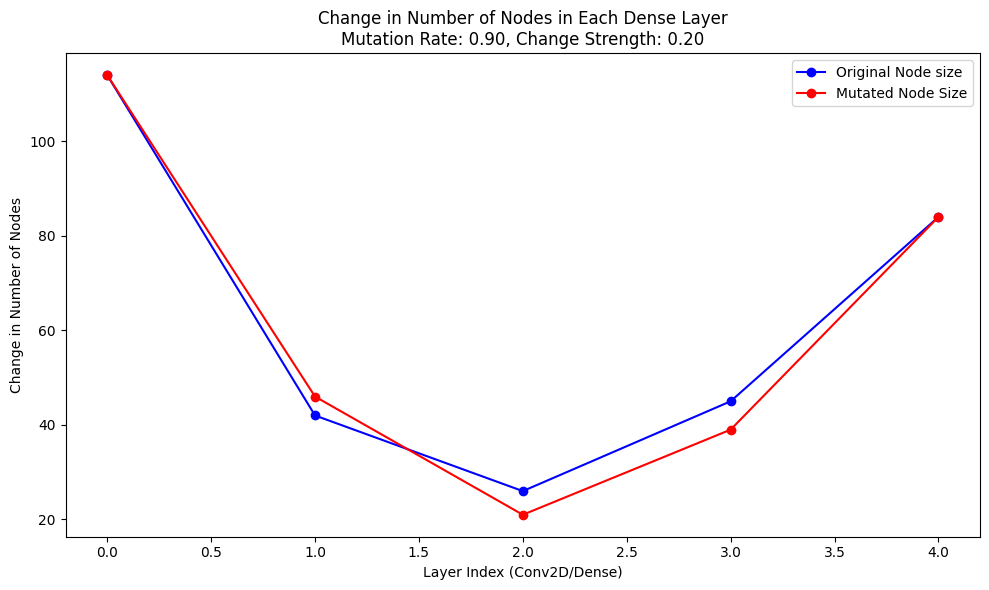

[['Conv2D', 114, (3, 5), 'relu', 0.00626814626325144],
 ['Conv2D', 46, (3, 4), 'sigmoid', 0.028494964655168896],
 ['MaxPooling2D', (4, 2)],
 ['Conv2D', 21, (3, 4), 'tanh', 0.1],
 ['Flatten'],
 ['Dense', 39, 'tanh', 0.09427769733435708],
 ['Dense', 84, 'sigmoid', 0.06527520941712979]]

In [8]:
def mutate(genome, mutation_rate=0.9, change_strength=0.2):

    mutated_genome = genome.copy()
    input_layer = mutated_genome[0]
    output_layer = mutated_genome[-1]

    for i in range(1, len(mutated_genome) - 1):
        if random.random() < mutation_rate:
            layer_params = mutated_genome[i]
            layer_type = layer_params[0]

            if layer_type == 'Conv2D':
                filters, kernel_size, activation, l2_strength = layer_params[1:]
                filters = max(16, min(128, int(filters * (1 + random.uniform(-change_strength, change_strength)))))
                l2_strength = max(0.0, min(0.1, l2_strength * (1 + random.uniform(-change_strength, change_strength))))
                mutated_genome[i] = [layer_type, filters, (random.randint(3, 5), random.randint(3, 5)), random.choice(['relu', 'sigmoid', 'tanh']), l2_strength]

            elif layer_type == 'MaxPooling2D':
                pool_size = layer_params[1]
                mutated_genome[i] = [layer_type, (random.randint(2, 4), random.randint(2, 4))]

            elif layer_type == 'Dense':
                units, activation, l2_strength = layer_params[1:]
                units = max(32, min(256, int(units * (1 + random.uniform(-change_strength, change_strength)))))
                l2_strength = max(0.0, min(0.1, l2_strength * (1 + random.uniform(-change_strength, change_strength))))
                mutated_genome[i] = [layer_type, units, random.choice(['relu', 'sigmoid', 'tanh']), l2_strength]

    mutated_genome[0] = input_layer
    mutated_genome[-1] = output_layer

    print("Original Genome: ", genome)
    print("Mutated Genome: ", mutated_genome)
    visualize_mutation(genome, mutated_genome, mutation_rate, change_strength)
    return mutated_genome


def crossover(parent1, parent2):
    """
    Performs crossover between two parent genomes representing neural network architectures.

    Args:
    - parent1: The first parent genome.
    - parent2: The second parent genome.

    Returns:
    - Two offspring genomes resulting from crossover.
    """
    # Find the index of the flatten layer in both parents
    flatten_index_parent1 = parent1.index(['Flatten'])
    flatten_index_parent2 = parent2.index(['Flatten'])

    # Split parent genomes into parts before and after the flatten layer
    before_flatten_parent1 = parent1[:flatten_index_parent1]
    after_flatten_parent1 = parent1[flatten_index_parent1 + 1:]

    before_flatten_parent2 = parent2[:flatten_index_parent2]
    after_flatten_parent2 = parent2[flatten_index_parent2 + 1:]

    # Perform crossover between the parts before and after the flatten layer
    offspring1_before = before_flatten_parent1 + after_flatten_parent2
    offspring2_before = before_flatten_parent2 + after_flatten_parent1

    # Merge the parts back with a flatten layer in the middle for both offspring
    offspring1 = offspring1_before[:flatten_index_parent1] + [['Flatten']] + offspring1_before[flatten_index_parent1:]
    offspring2 = offspring2_before[:flatten_index_parent2] + [['Flatten']] + offspring2_before[flatten_index_parent2:]

    visualize_crossover(parent1, parent2, offspring1, offspring2)
    return offspring1, offspring2

def fix_model(model):
    """
    Fixes the model by ensuring it contains a single flatten layer.

    Args:
    - model: The model genome.

    Returns:
    - The fixed model genome.
    """
    if model.count(['Flatten']) > 1:
        # Remove all but the first flatten layer
        model = [layer for layer in model if layer != ['Flatten']]  # Remove all flatten layers
        first_flatten_index = model.index(['Dense']) + 1  # Find the index of the first dense layer
        model.insert(first_flatten_index, ['Flatten'])  # Insert a single flatten layer before the first dense layer
    elif model.count(['Flatten']) == 0:
        # If there's no flatten layer, insert one after the last convolutional layer or global pooling layer
        last_conv_index = next((i for i, layer in reversed(list(enumerate(model))) if layer[0] == 'Conv2D'), None)
        last_pool_index = next((i for i, layer in reversed(list(enumerate(model))) if layer[0] == 'GlobalPooling2D'), None)
        insert_index = max(last_conv_index, last_pool_index) + 1 if last_conv_index is not None or last_pool_index is not None else 1
        model.insert(insert_index, ['Flatten'])

    return model

def select_parents(population, fitness_scores, num_parents):

    parents = []
    sorted_indices = np.argsort(fitness_scores)[::-1]
    for i in range(num_parents):
        parents.append(population[sorted_indices[i]])

    visualize_selection(population, fitness_scores, parents)
    return parents


mutate(get_random_model())
#crossover(get_random_model(), get_random_model())


In [9]:
def evaluate_individual(individual, train_data, train_labels_one_hot, test_data, test_labels_one_hot):

    model = create_model_from_genome(individual)
    if model is None:
        print(0.0)
        return 0.0  # Return a fitness score of 0.0 for invalid individuals
    print("Fitting...")
    start_time = time.time()
    model.fit(train_data, train_labels_one_hot, epochs=4, batch_size=128, verbose=0)
    finish_time = time.time()
    execution_time = finish_time - start_time
    print("Fitted in ", abs(execution_time), "'s.")
    _, accuracy = model.evaluate(test_data, test_labels_one_hot, verbose=0)
    print("Accuracy is ", accuracy)
    return accuracy

def evaluate_fitness_score(accuracy):
    # Define weights for accuracy and time taken
    accuracy_weight = 0.7  # Adjust as needed
    time_weight = 0.3  # Adjust as needed

    return round(accuracy * 100, 5)

def evaluate_population(population, train_data, train_labels_one_hot, test_data, test_labels_one_hot):

    fitness_scores = []
    print("Evaluating all Models.")
    for idx, individual in enumerate(population):
        accuracy = evaluate_individual(individual, train_data, train_labels_one_hot, test_data, test_labels_one_hot)
        fitness = evaluate_fitness_score(accuracy)
        print("Model ", idx, " Fitness: ", fitness)
        fitness_scores.append(fitness)
    print("All models evaluted.")
    return fitness_scores


In [10]:
def display_generation_individuals(population, scores, generation, mean_accuracy):

    models = []
    for individual in population:
        model = create_model_from_genome(individual)  # Assuming you have a function like this
        models.append(model)

    num_models = len(models)
    # Create subplots for each model
    fig, axs = plt.subplots(1, num_models, figsize=(15, 5))

    # Loop through each model and visualize
    for i, (model, fitness_score) in enumerate(zip(models, scores)):
        # Visualize the model
        plot_model(model, to_file=f'model_plot_{i}.png', show_shapes=True, show_layer_names=True)

        # Display the image in the corresponding subplot
        img = plt.imread(f'model_plot_{i}.png')
        axs[i].imshow(img)
        axs[i].axis('off')

        # Annotate with fitness score
        axs[i].annotate(f'Fitness Score: {fitness_score}', xy=(0.5, -0.1), xycoords='axes fraction', ha='center')

    plt.suptitle(f"Generation {generation} , Mean Accuracy {mean_accuracy}")
    plt.show()


def display_model(model, accuracy):

    idx = random.randint(1, 500)
    plot_model(model, to_file=f'model_plot_{idx}.png', show_shapes=True, show_layer_names=True)
    img = plt.imread(f'model_plot_{idx}.png')
    plt.imshow(img)
    plt.axis('off')
    if accuracy != None:
      plt.annotate(f'Accuracy: {accuracy}', xy=(0.5, -0.1), xycoords='axes fraction', ha='center')


In [24]:
def genetic_algorithm(population_size, generations, num_parents=2):

    print("Loading data...")
    train_data, train_labels = load_data( max_images_per_category=5)

    train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2)
    train_data = train_data / 255.0
    test_data = test_data / 255.0
    train_labels_one_hot = to_categorical(train_labels, num_classes=num_characters)
    test_labels_one_hot = to_categorical(test_labels, num_classes=num_characters)

    population = initialize_population(population_size)
    mean_accuracy_over_generations = []
    best_model = None
    best_accuracy = 0
    for generation in range(generations):
        average_fitness = 0
        print("GENERATION: ", generation)
        fitness_scores = evaluate_population(population, train_data, train_labels_one_hot, test_data, test_labels_one_hot)
        for score in fitness_scores:
          average_fitness += score
        average_fitness = average_fitness / len(fitness_scores)
        mean_accuracy_over_generations.append(average_fitness)

        best_individual_index = fitness_scores.index(max(fitness_scores))
        best_individual_accuracy = fitness_scores[best_individual_index]

        if best_individual_accuracy > best_accuracy:
            print("New best model found")
            best_model = population[best_individual_index]
            best_accuracy = best_individual_accuracy

        display_generation_individuals(population, fitness_scores, generation, average_fitness) # Display individuals and accuracies
        print("GENERATION FINSIHED")
        parents = select_parents(population, fitness_scores, num_parents)
        print("Parents: ",parents)
        fill = []
        for parent1, parent2 in zip(parents[::2], parents[1::2]):
            offspring1, offspring2 = crossover(parent1, parent2)
            if len(population) - 2 > 0:
              for _ in range(len(population) - 2):
                x = random.randint(1, 3)
                if x == 1:
                  fill.append(mutate(offspring1))
                elif x == 2:
                  fill.append(mutate(offspring2))
                else:
                  fill.append(get_random_model())

        population = [offspring1, offspring2] + fill

    final_model = create_model_from_genome(best_model)
    return final_model, test_data, test_labels, mean_accuracy_over_generations

Loading data...
Loaded 50 images.
GENERATION:  0
Evaluating all Models.
Genomes:  [['Conv2D', 39, (5, 3), 'relu', 0.05694016444372803], ['Conv2D', 54, (5, 5), 'sigmoid', 0.08097451759846641], ['MaxPooling2D', (3, 2)], ['Conv2D', 48, (3, 5), 'sigmoid', 0.040249614489321274], ['Conv2D', 41, (4, 3), 'sigmoid', 0.007294738872103224], ['Flatten'], ['Dense', 33, 'sigmoid', 0.0797222267648684]]
Compiled
Fitting...
Fitted in  13.767358779907227 's.
Accuracy is  0.10000000149011612
Model  0  Fitness:  10.0
Genomes:  [['Conv2D', 19, (3, 5), 'relu', 0.0073211163783562854], ['Conv2D', 32, (5, 4), 'relu', 0.0195058353834636], ['Flatten'], ['Dense', 109, 'tanh', 0.00828324442094075], ['Dense', 93, 'tanh', 0.05903455421467712], ['Dense', 166, 'relu', 0.03474262084558836]]
Compiled
Fitting...
Fitted in  5.386198282241821 's.
Accuracy is  0.20000000298023224
Model  1  Fitness:  20.0
Genomes:  [['Conv2D', 35, (3, 5), 'relu', 0.050715912387737795], ['MaxPooling2D', (3, 3)], ['Conv2D', 118, (4, 4), 'sigmo

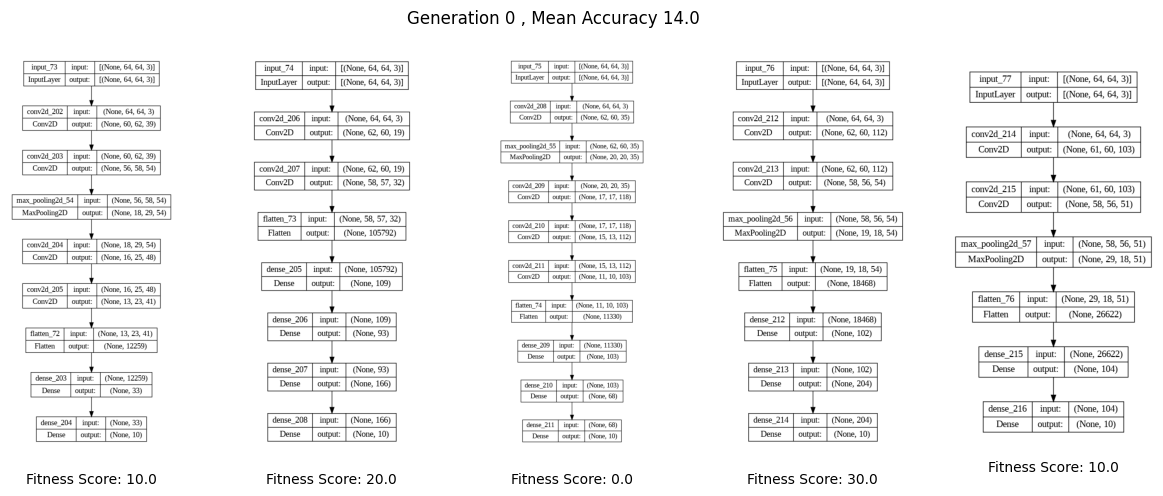

GENERATION FINSIHED


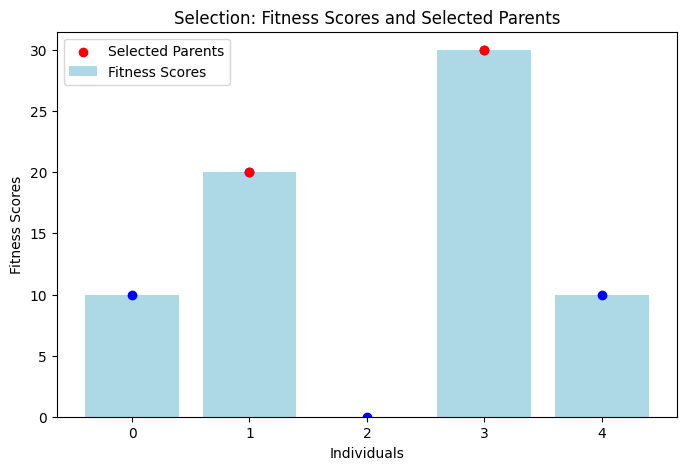

Parents:  [[['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 54, (5, 5), 'tanh', 0.09625996033547808], ['MaxPooling2D', (3, 3)], ['Flatten'], ['Dense', 102, 'relu', 0.057051559162882785], ['Dense', 204, 'relu', 0.08363504448978436]], [['Conv2D', 19, (3, 5), 'relu', 0.0073211163783562854], ['Conv2D', 32, (5, 4), 'relu', 0.0195058353834636], ['Flatten'], ['Dense', 109, 'tanh', 0.00828324442094075], ['Dense', 93, 'tanh', 0.05903455421467712], ['Dense', 166, 'relu', 0.03474262084558836]]]


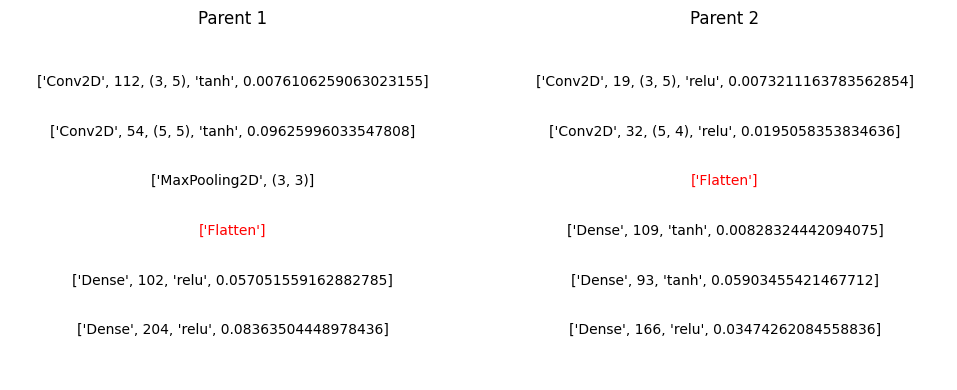

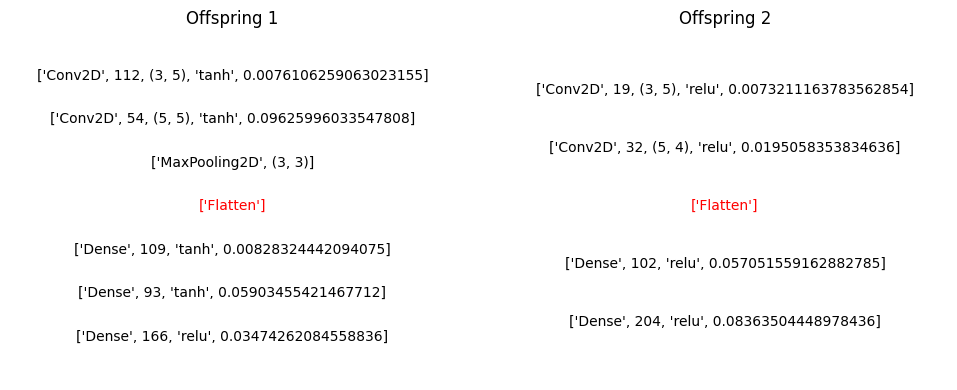

Original Genome:  [['Conv2D', 19, (3, 5), 'relu', 0.0073211163783562854], ['Conv2D', 32, (5, 4), 'relu', 0.0195058353834636], ['Flatten'], ['Dense', 102, 'relu', 0.057051559162882785], ['Dense', 204, 'relu', 0.08363504448978436]]
Mutated Genome:  [['Conv2D', 19, (3, 5), 'relu', 0.0073211163783562854], ['Conv2D', 30, (3, 4), 'tanh', 0.02068210385296848], ['Flatten'], ['Dense', 120, 'relu', 0.05062711905332984], ['Dense', 204, 'relu', 0.08363504448978436]]


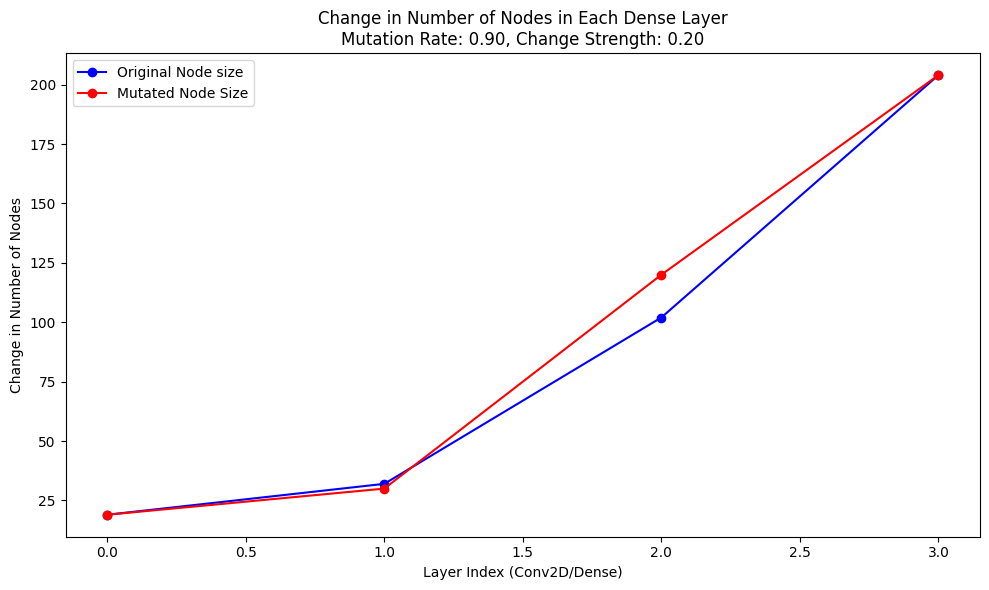

Original Genome:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 54, (5, 5), 'tanh', 0.09625996033547808], ['MaxPooling2D', (3, 3)], ['Flatten'], ['Dense', 109, 'tanh', 0.00828324442094075], ['Dense', 93, 'tanh', 0.05903455421467712], ['Dense', 166, 'relu', 0.03474262084558836]]
Mutated Genome:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 55, (4, 3), 'tanh', 0.1], ['MaxPooling2D', (3, 2)], ['Flatten'], ['Dense', 92, 'sigmoid', 0.009220011759264393], ['Dense', 109, 'tanh', 0.06325828843510677], ['Dense', 166, 'relu', 0.03474262084558836]]


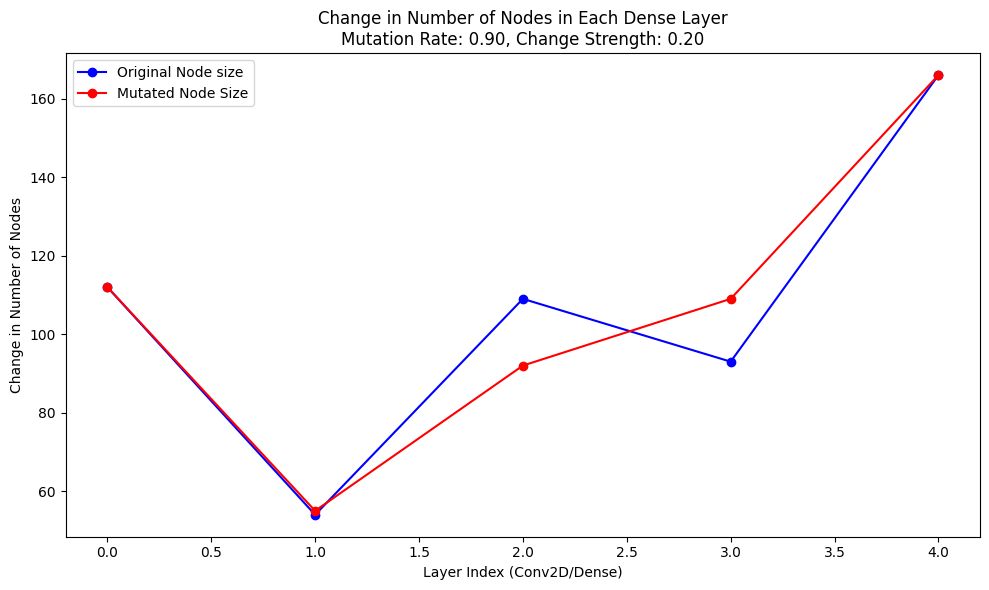

GENERATION:  1
Evaluating all Models.
Genomes:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 54, (5, 5), 'tanh', 0.09625996033547808], ['MaxPooling2D', (3, 3)], ['Flatten'], ['Dense', 109, 'tanh', 0.00828324442094075], ['Dense', 93, 'tanh', 0.05903455421467712], ['Dense', 166, 'relu', 0.03474262084558836]]
Compiled
Fitting...
Fitted in  22.18877673149109 's.
Accuracy is  0.30000001192092896
Model  0  Fitness:  30.0
Genomes:  [['Conv2D', 19, (3, 5), 'relu', 0.0073211163783562854], ['Conv2D', 32, (5, 4), 'relu', 0.0195058353834636], ['Flatten'], ['Dense', 102, 'relu', 0.057051559162882785], ['Dense', 204, 'relu', 0.08363504448978436]]
Compiled
Fitting...
Fitted in  3.640496015548706 's.
Accuracy is  0.10000000149011612
Model  1  Fitness:  10.0
Genomes:  [['Conv2D', 19, (3, 5), 'relu', 0.0073211163783562854], ['Conv2D', 30, (3, 4), 'tanh', 0.02068210385296848], ['Flatten'], ['Dense', 120, 'relu', 0.05062711905332984], ['Dense', 204, 'relu', 0.08363504448978436]]
Com

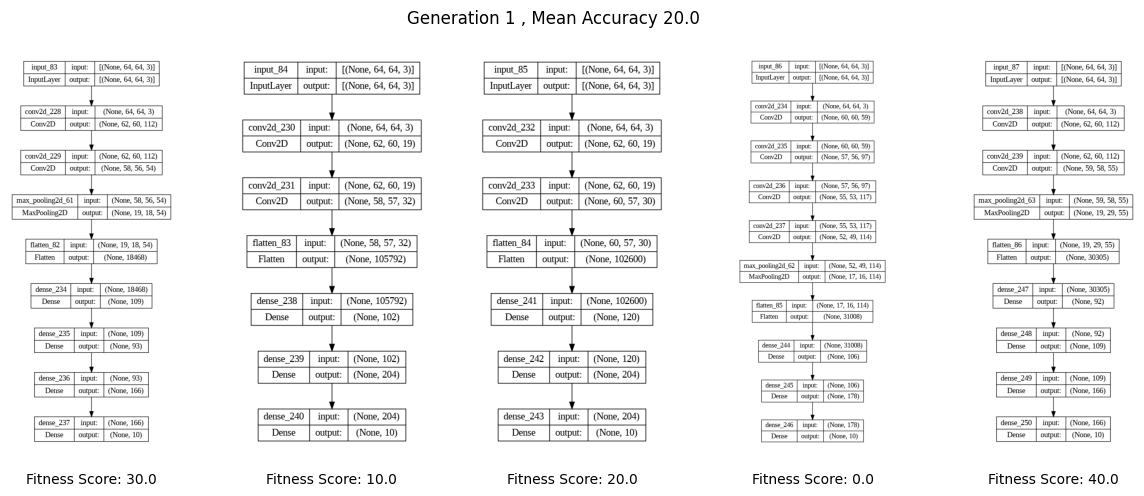

GENERATION FINSIHED


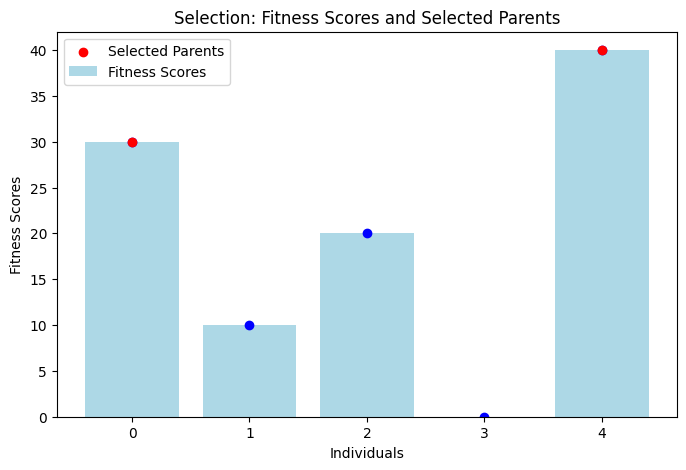

Parents:  [[['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 55, (4, 3), 'tanh', 0.1], ['MaxPooling2D', (3, 2)], ['Flatten'], ['Dense', 92, 'sigmoid', 0.009220011759264393], ['Dense', 109, 'tanh', 0.06325828843510677], ['Dense', 166, 'relu', 0.03474262084558836]], [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 54, (5, 5), 'tanh', 0.09625996033547808], ['MaxPooling2D', (3, 3)], ['Flatten'], ['Dense', 109, 'tanh', 0.00828324442094075], ['Dense', 93, 'tanh', 0.05903455421467712], ['Dense', 166, 'relu', 0.03474262084558836]]]


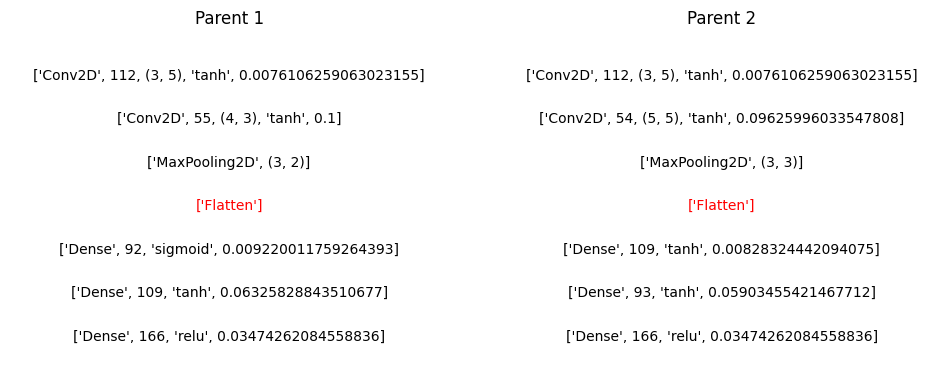

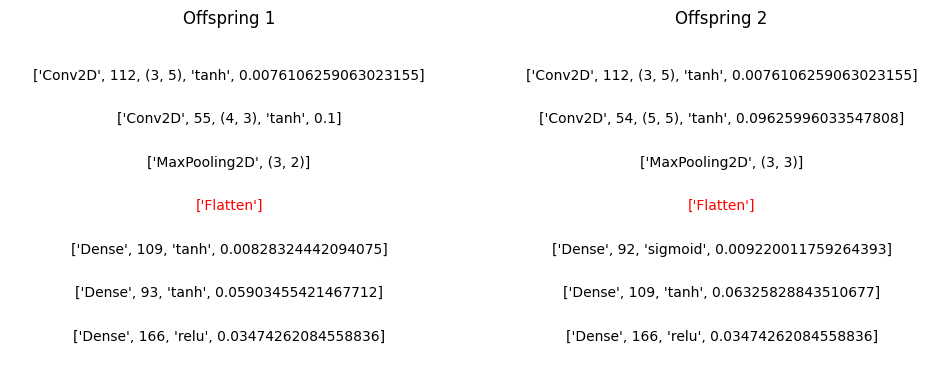

Original Genome:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 55, (4, 3), 'tanh', 0.1], ['MaxPooling2D', (3, 2)], ['Flatten'], ['Dense', 109, 'tanh', 0.00828324442094075], ['Dense', 93, 'tanh', 0.05903455421467712], ['Dense', 166, 'relu', 0.03474262084558836]]
Mutated Genome:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 65, (5, 5), 'tanh', 0.1], ['MaxPooling2D', (2, 2)], ['Flatten'], ['Dense', 100, 'sigmoid', 0.006650421448268511], ['Dense', 91, 'sigmoid', 0.06669162009768075], ['Dense', 166, 'relu', 0.03474262084558836]]


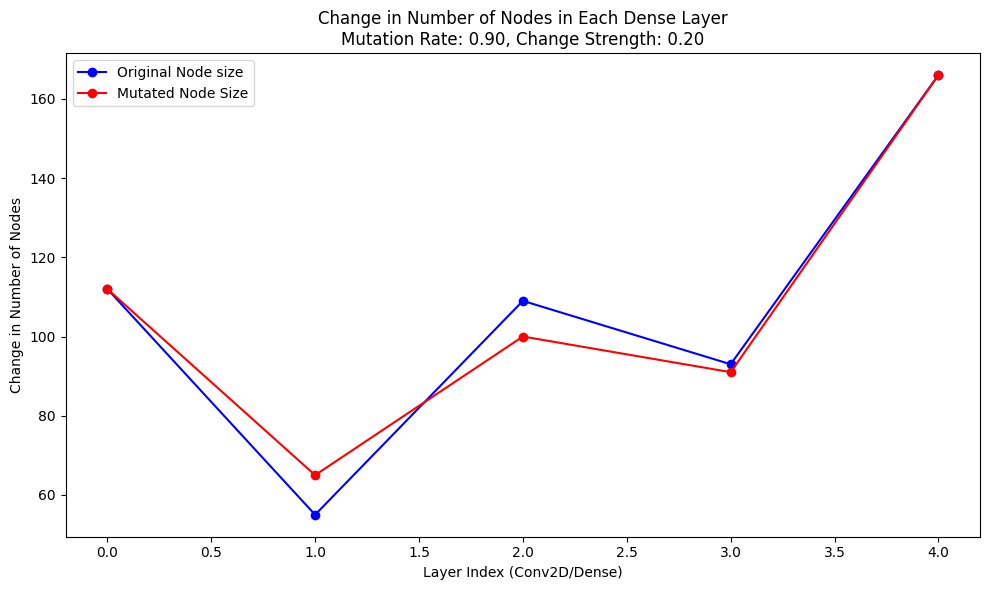

Original Genome:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 55, (4, 3), 'tanh', 0.1], ['MaxPooling2D', (3, 2)], ['Flatten'], ['Dense', 109, 'tanh', 0.00828324442094075], ['Dense', 93, 'tanh', 0.05903455421467712], ['Dense', 166, 'relu', 0.03474262084558836]]
Mutated Genome:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 59, (4, 4), 'tanh', 0.1], ['MaxPooling2D', (2, 4)], ['Flatten'], ['Dense', 130, 'tanh', 0.009279462558800957], ['Dense', 100, 'relu', 0.05977545633052405], ['Dense', 166, 'relu', 0.03474262084558836]]


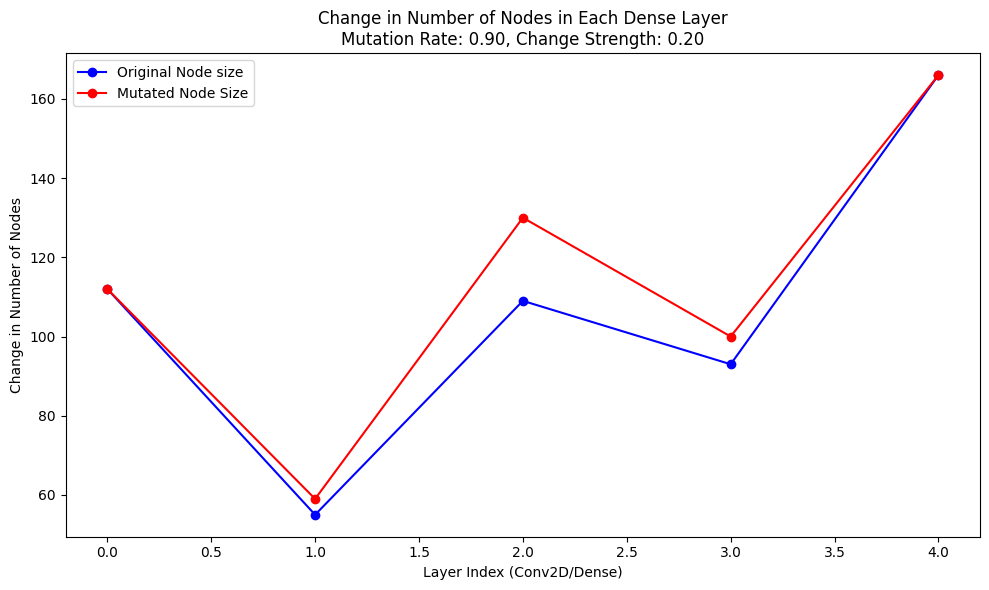

GENERATION:  2
Evaluating all Models.
Genomes:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 55, (4, 3), 'tanh', 0.1], ['MaxPooling2D', (3, 2)], ['Flatten'], ['Dense', 109, 'tanh', 0.00828324442094075], ['Dense', 93, 'tanh', 0.05903455421467712], ['Dense', 166, 'relu', 0.03474262084558836]]
Compiled
Fitting...
Fitted in  11.845287799835205 's.
Accuracy is  0.30000001192092896
Model  0  Fitness:  30.0
Genomes:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 54, (5, 5), 'tanh', 0.09625996033547808], ['MaxPooling2D', (3, 3)], ['Flatten'], ['Dense', 92, 'sigmoid', 0.009220011759264393], ['Dense', 109, 'tanh', 0.06325828843510677], ['Dense', 166, 'relu', 0.03474262084558836]]
Compiled
Fitting...
Fitted in  13.188354969024658 's.
Accuracy is  0.4000000059604645
Model  1  Fitness:  40.0
Genomes:  [['Conv2D', 73, (5, 4), 'relu', 0.0953382846128813], ['MaxPooling2D', (2, 3)], ['Flatten'], ['Dense', 214, 'sigmoid', 0.09561787744401448]]
Compiled
Fittin

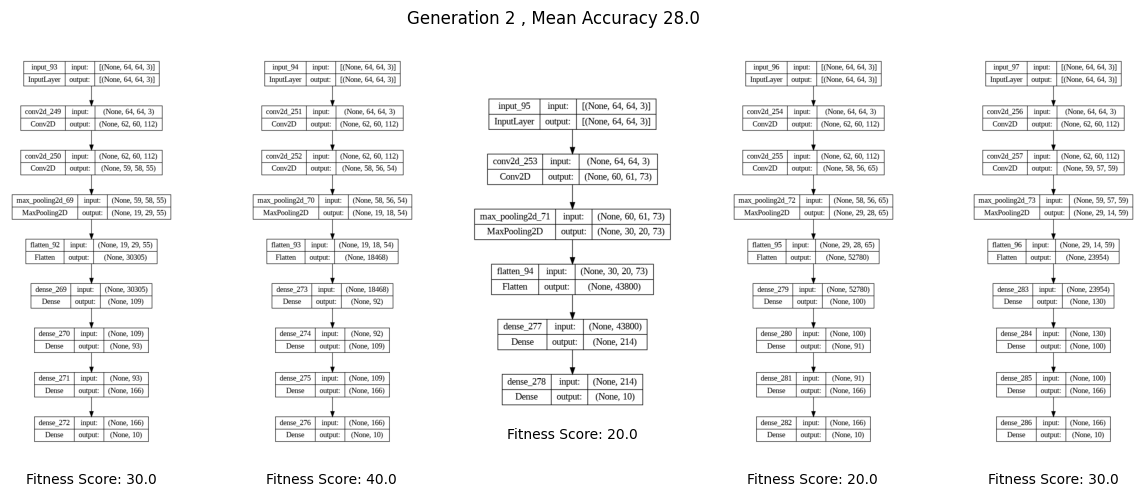

GENERATION FINSIHED


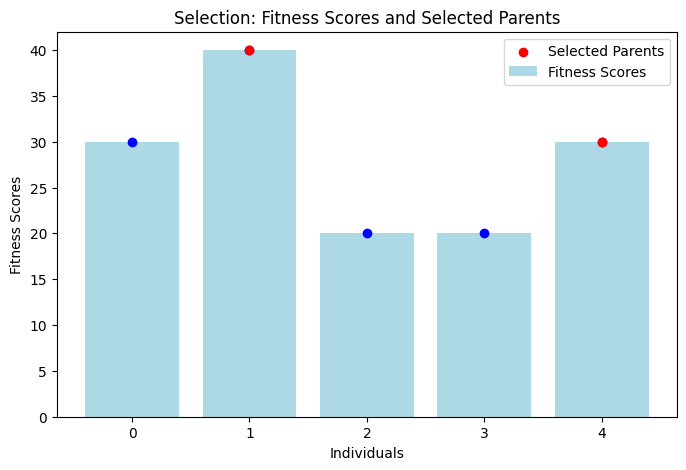

Parents:  [[['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 54, (5, 5), 'tanh', 0.09625996033547808], ['MaxPooling2D', (3, 3)], ['Flatten'], ['Dense', 92, 'sigmoid', 0.009220011759264393], ['Dense', 109, 'tanh', 0.06325828843510677], ['Dense', 166, 'relu', 0.03474262084558836]], [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 59, (4, 4), 'tanh', 0.1], ['MaxPooling2D', (2, 4)], ['Flatten'], ['Dense', 130, 'tanh', 0.009279462558800957], ['Dense', 100, 'relu', 0.05977545633052405], ['Dense', 166, 'relu', 0.03474262084558836]]]


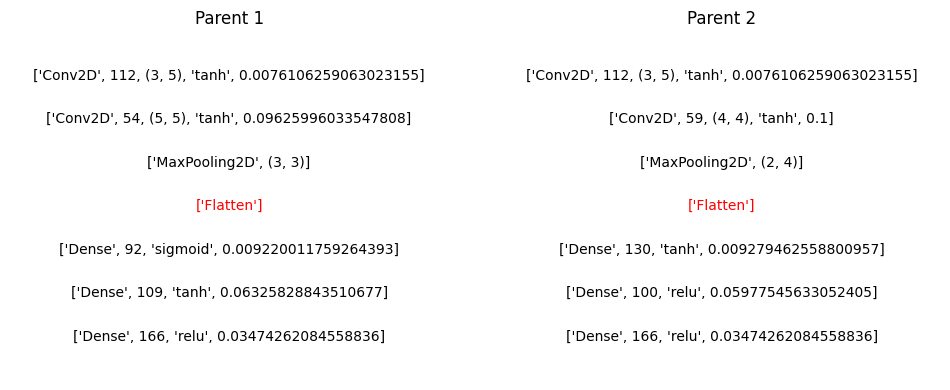

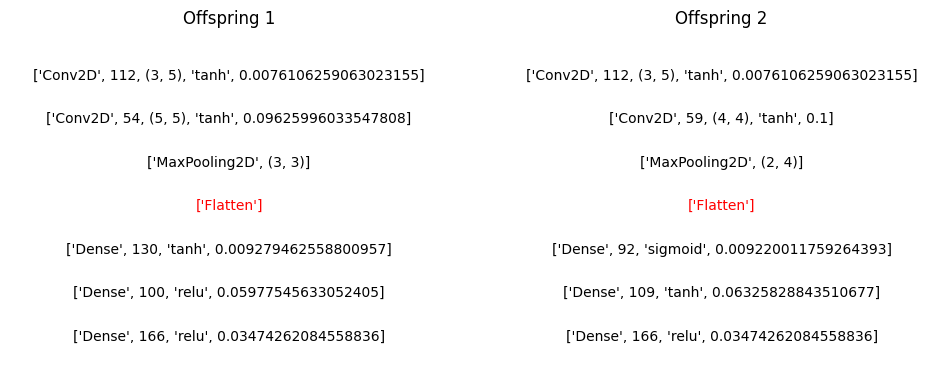

Original Genome:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 59, (4, 4), 'tanh', 0.1], ['MaxPooling2D', (2, 4)], ['Flatten'], ['Dense', 92, 'sigmoid', 0.009220011759264393], ['Dense', 109, 'tanh', 0.06325828843510677], ['Dense', 166, 'relu', 0.03474262084558836]]
Mutated Genome:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 58, (5, 3), 'relu', 0.09469245172312224], ['MaxPooling2D', (2, 4)], ['Flatten'], ['Dense', 80, 'tanh', 0.009378088302664516], ['Dense', 110, 'tanh', 0.07057718861048302], ['Dense', 166, 'relu', 0.03474262084558836]]


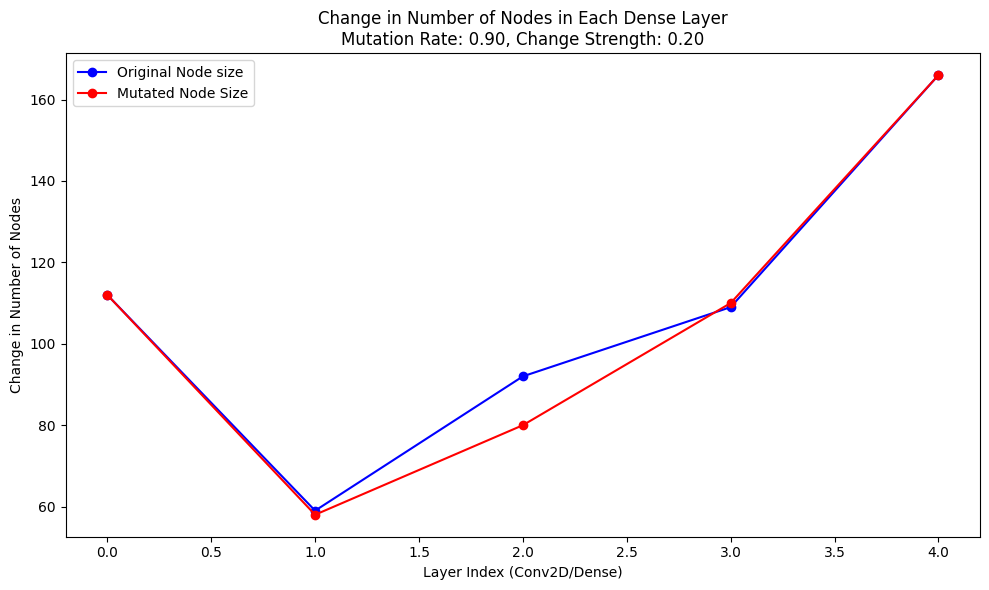

GENERATION:  3
Evaluating all Models.
Genomes:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 54, (5, 5), 'tanh', 0.09625996033547808], ['MaxPooling2D', (3, 3)], ['Flatten'], ['Dense', 130, 'tanh', 0.009279462558800957], ['Dense', 100, 'relu', 0.05977545633052405], ['Dense', 166, 'relu', 0.03474262084558836]]
Compiled
Fitting...
Fitted in  21.748504161834717 's.
Accuracy is  0.20000000298023224
Model  0  Fitness:  20.0
Genomes:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 59, (4, 4), 'tanh', 0.1], ['MaxPooling2D', (2, 4)], ['Flatten'], ['Dense', 92, 'sigmoid', 0.009220011759264393], ['Dense', 109, 'tanh', 0.06325828843510677], ['Dense', 166, 'relu', 0.03474262084558836]]
Compiled
Fitting...
Fitted in  9.25436019897461 's.
Accuracy is  0.20000000298023224
Model  1  Fitness:  20.0
Genomes:  [['Conv2D', 72, (5, 4), 'tanh', 0.07889977208306163], ['MaxPooling2D', (3, 3)], ['Conv2D', 77, (5, 3), 'relu', 0.09214494516940308], ['Conv2D', 26, (5, 3)

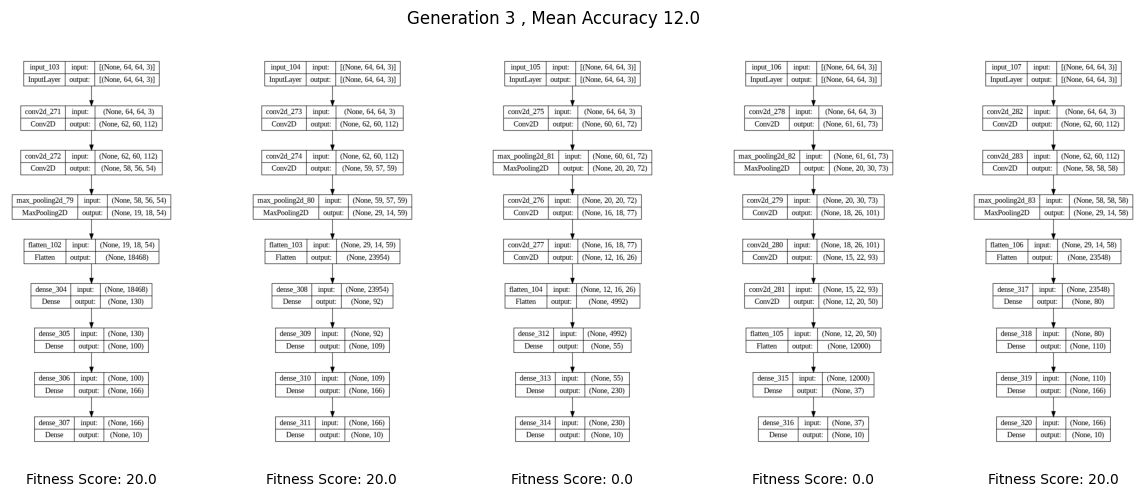

GENERATION FINSIHED


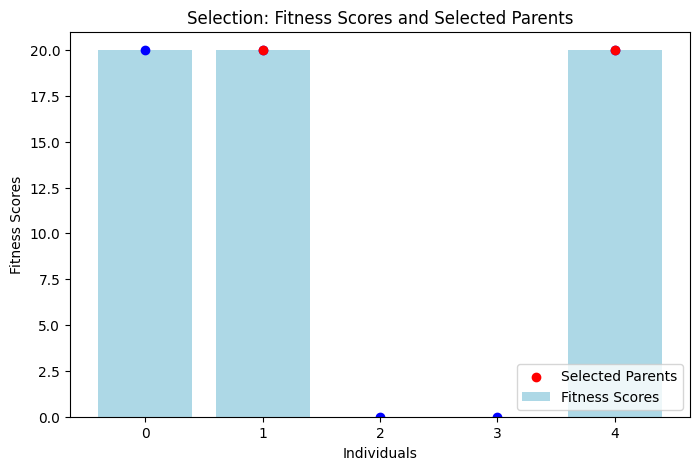

Parents:  [[['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 58, (5, 3), 'relu', 0.09469245172312224], ['MaxPooling2D', (2, 4)], ['Flatten'], ['Dense', 80, 'tanh', 0.009378088302664516], ['Dense', 110, 'tanh', 0.07057718861048302], ['Dense', 166, 'relu', 0.03474262084558836]], [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 59, (4, 4), 'tanh', 0.1], ['MaxPooling2D', (2, 4)], ['Flatten'], ['Dense', 92, 'sigmoid', 0.009220011759264393], ['Dense', 109, 'tanh', 0.06325828843510677], ['Dense', 166, 'relu', 0.03474262084558836]]]


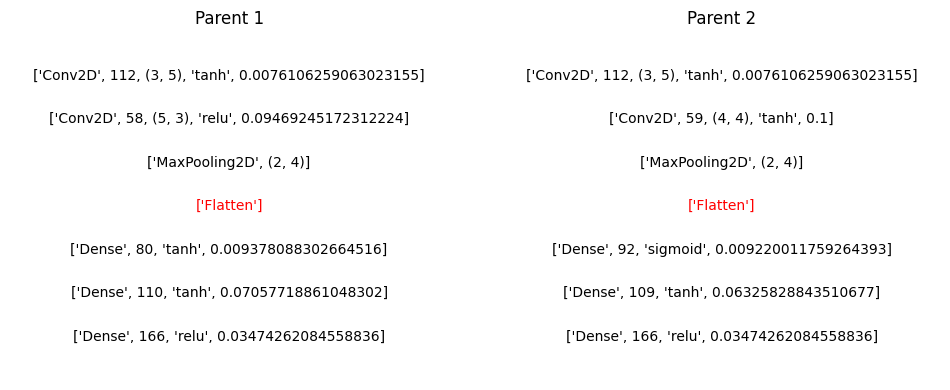

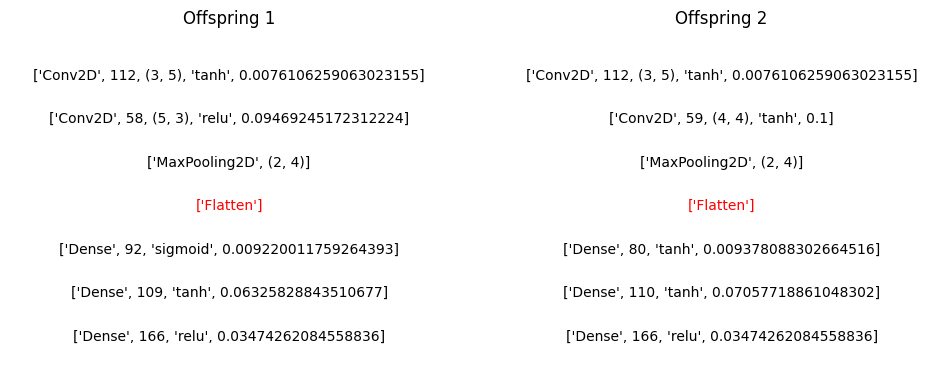

Original Genome:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 59, (4, 4), 'tanh', 0.1], ['MaxPooling2D', (2, 4)], ['Flatten'], ['Dense', 80, 'tanh', 0.009378088302664516], ['Dense', 110, 'tanh', 0.07057718861048302], ['Dense', 166, 'relu', 0.03474262084558836]]
Mutated Genome:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 60, (4, 5), 'sigmoid', 0.08683372123294264], ['MaxPooling2D', (4, 3)], ['Flatten'], ['Dense', 95, 'relu', 0.011072250484608043], ['Dense', 93, 'relu', 0.05903929547378813], ['Dense', 166, 'relu', 0.03474262084558836]]


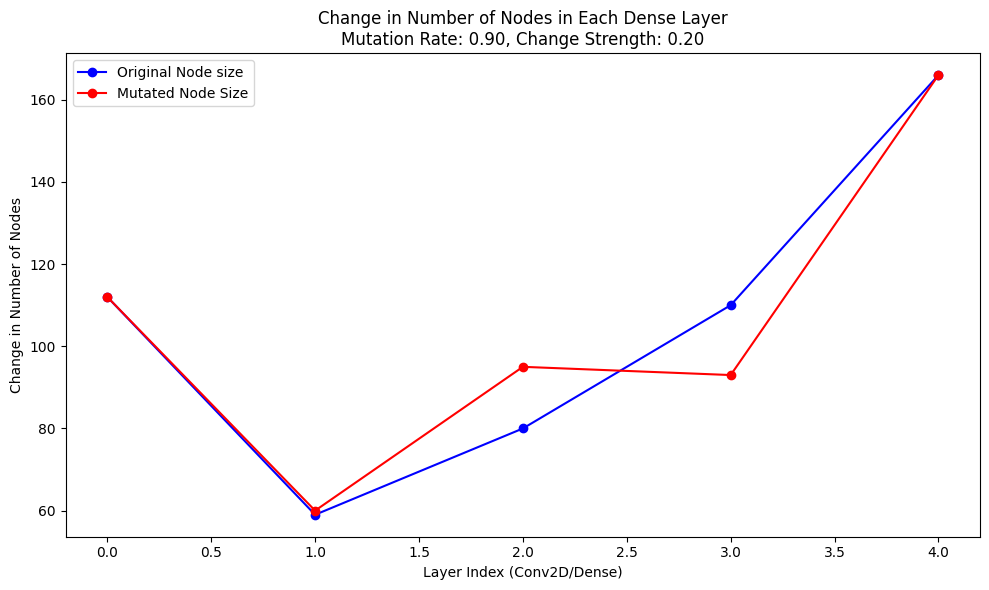

Original Genome:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 58, (5, 3), 'relu', 0.09469245172312224], ['MaxPooling2D', (2, 4)], ['Flatten'], ['Dense', 92, 'sigmoid', 0.009220011759264393], ['Dense', 109, 'tanh', 0.06325828843510677], ['Dense', 166, 'relu', 0.03474262084558836]]
Mutated Genome:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 55, (4, 5), 'tanh', 0.1], ['MaxPooling2D', (4, 3)], ['Flatten'], ['Dense', 91, 'relu', 0.009255657937289549], ['Dense', 112, 'relu', 0.05222048247427612], ['Dense', 166, 'relu', 0.03474262084558836]]


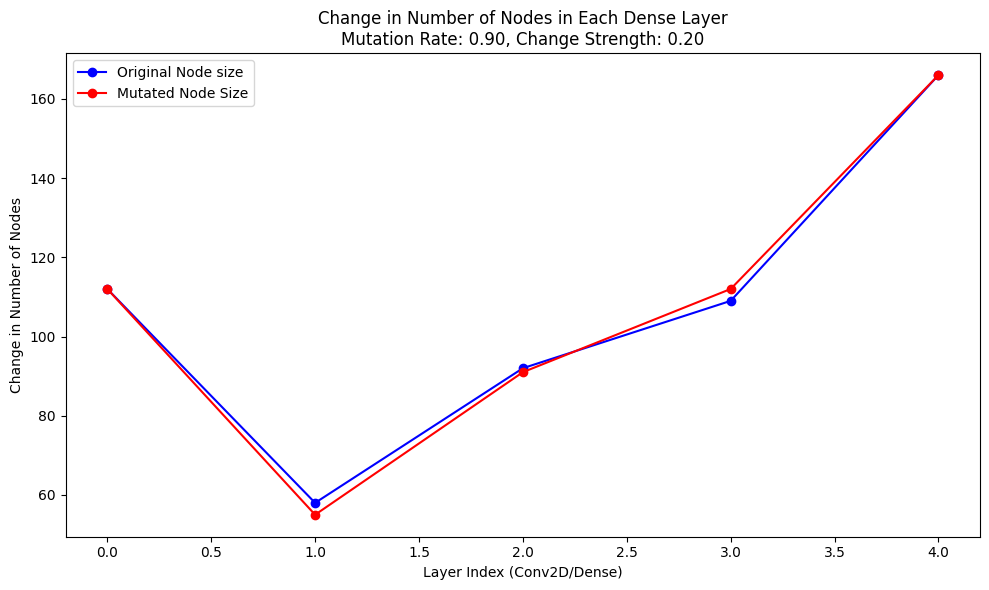

GENERATION:  4
Evaluating all Models.
Genomes:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 58, (5, 3), 'relu', 0.09469245172312224], ['MaxPooling2D', (2, 4)], ['Flatten'], ['Dense', 92, 'sigmoid', 0.009220011759264393], ['Dense', 109, 'tanh', 0.06325828843510677], ['Dense', 166, 'relu', 0.03474262084558836]]
Compiled
Fitting...
Fitted in  11.431773900985718 's.
Accuracy is  0.20000000298023224
Model  0  Fitness:  20.0
Genomes:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 59, (4, 4), 'tanh', 0.1], ['MaxPooling2D', (2, 4)], ['Flatten'], ['Dense', 80, 'tanh', 0.009378088302664516], ['Dense', 110, 'tanh', 0.07057718861048302], ['Dense', 166, 'relu', 0.03474262084558836]]
Compiled
Fitting...
Fitted in  11.392595052719116 's.
Accuracy is  0.20000000298023224
Model  1  Fitness:  20.0
Genomes:  [['Conv2D', 104, (4, 3), 'tanh', 0.002351172792025225], ['Conv2D', 124, (5, 3), 'relu', 0.04340449115375945], ['Conv2D', 29, (5, 4), 'tanh', 0.0058175588

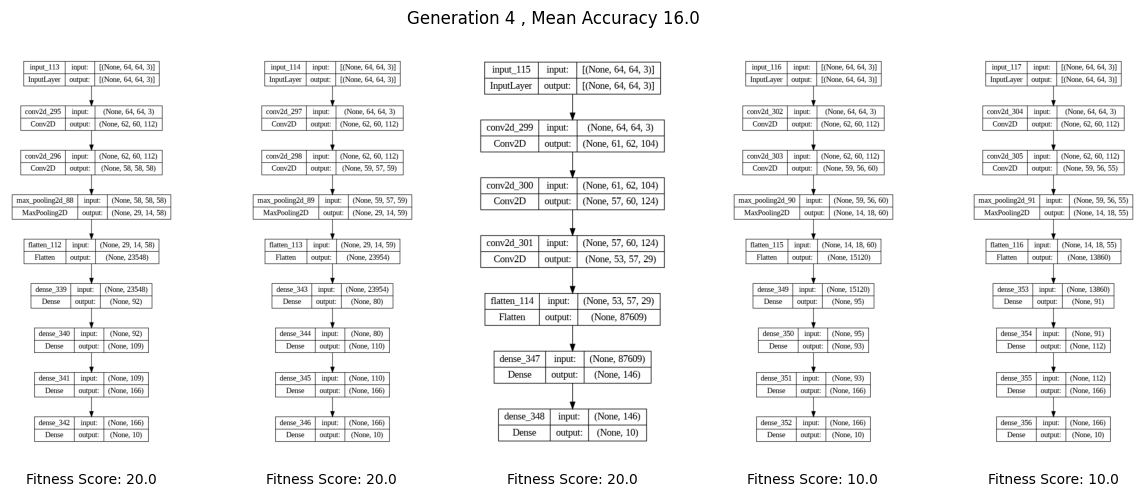

GENERATION FINSIHED


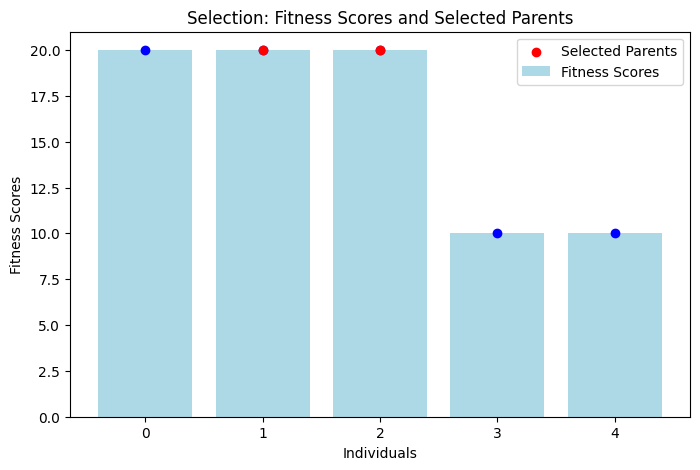

Parents:  [[['Conv2D', 104, (4, 3), 'tanh', 0.002351172792025225], ['Conv2D', 124, (5, 3), 'relu', 0.04340449115375945], ['Conv2D', 29, (5, 4), 'tanh', 0.00581755886487868], ['Flatten'], ['Dense', 146, 'sigmoid', 0.02246948185401545]], [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 59, (4, 4), 'tanh', 0.1], ['MaxPooling2D', (2, 4)], ['Flatten'], ['Dense', 80, 'tanh', 0.009378088302664516], ['Dense', 110, 'tanh', 0.07057718861048302], ['Dense', 166, 'relu', 0.03474262084558836]]]


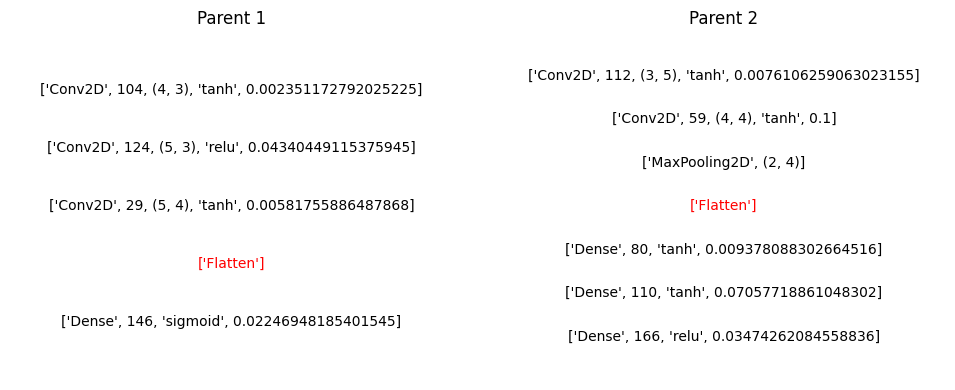

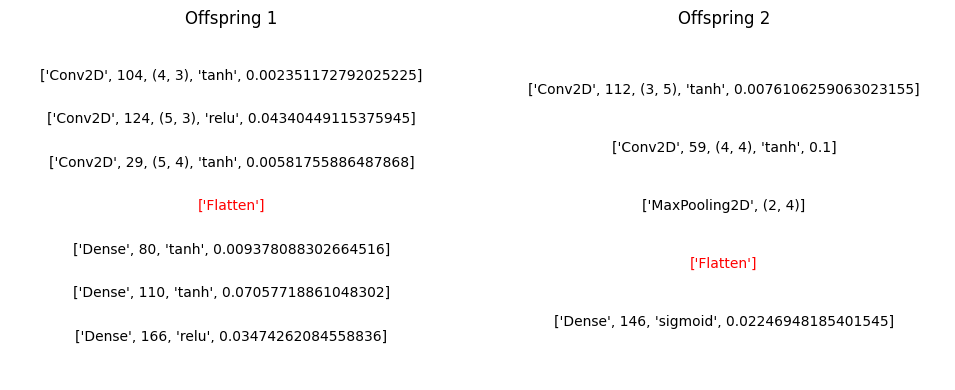

Original Genome:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 59, (4, 4), 'tanh', 0.1], ['MaxPooling2D', (2, 4)], ['Flatten'], ['Dense', 146, 'sigmoid', 0.02246948185401545]]
Mutated Genome:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 48, (4, 3), 'tanh', 0.08757883426414188], ['MaxPooling2D', (2, 4)], ['Flatten'], ['Dense', 146, 'sigmoid', 0.02246948185401545]]


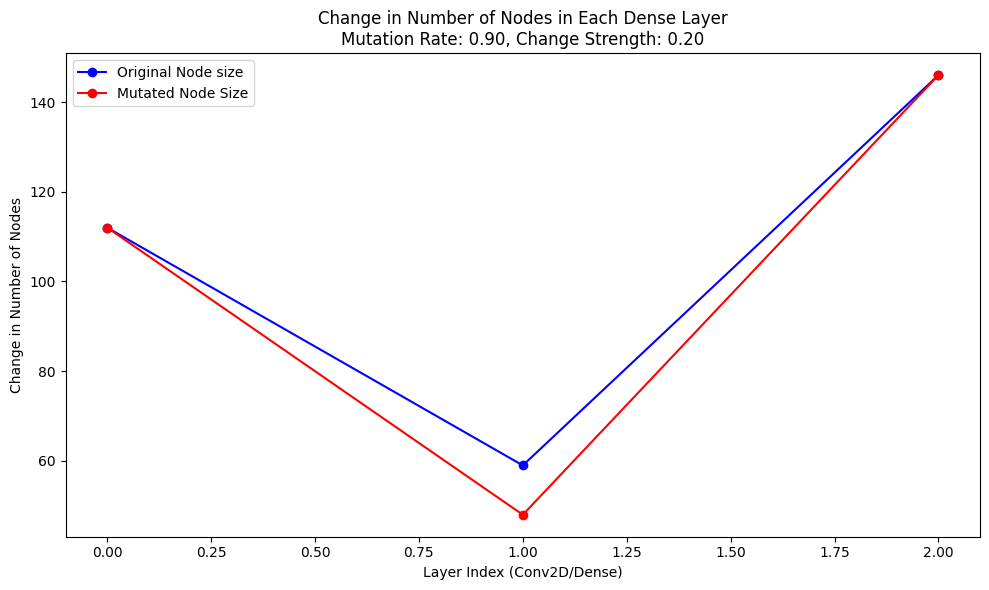

Original Genome:  [['Conv2D', 104, (4, 3), 'tanh', 0.002351172792025225], ['Conv2D', 124, (5, 3), 'relu', 0.04340449115375945], ['Conv2D', 29, (5, 4), 'tanh', 0.00581755886487868], ['Flatten'], ['Dense', 80, 'tanh', 0.009378088302664516], ['Dense', 110, 'tanh', 0.07057718861048302], ['Dense', 166, 'relu', 0.03474262084558836]]
Mutated Genome:  [['Conv2D', 104, (4, 3), 'tanh', 0.002351172792025225], ['Conv2D', 128, (5, 5), 'sigmoid', 0.051269813042552195], ['Conv2D', 27, (3, 4), 'relu', 0.005872284001877685], ['Flatten'], ['Dense', 87, 'relu', 0.008940723499015708], ['Dense', 117, 'sigmoid', 0.07327271089698771], ['Dense', 166, 'relu', 0.03474262084558836]]


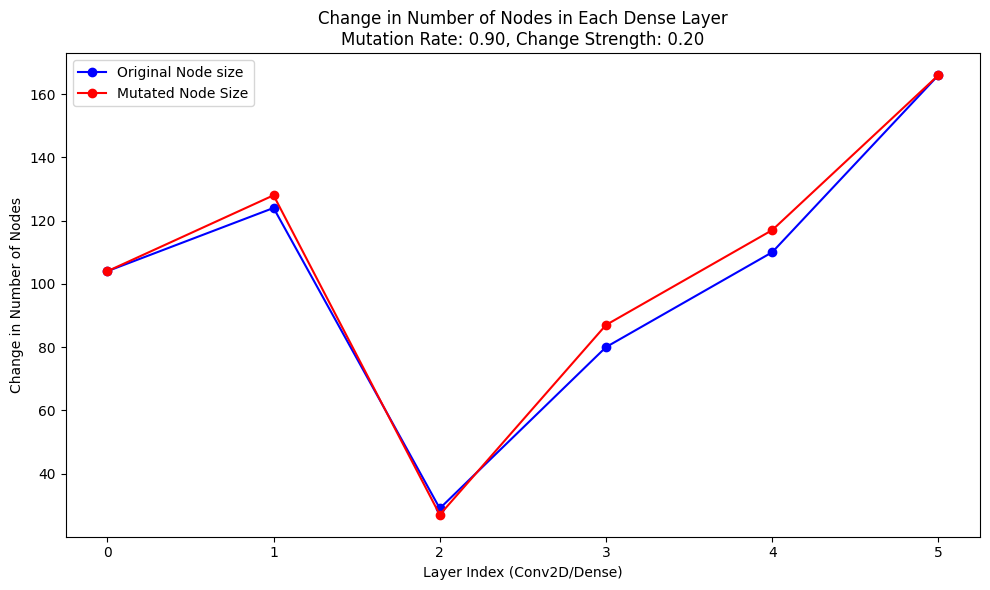

Original Genome:  [['Conv2D', 104, (4, 3), 'tanh', 0.002351172792025225], ['Conv2D', 124, (5, 3), 'relu', 0.04340449115375945], ['Conv2D', 29, (5, 4), 'tanh', 0.00581755886487868], ['Flatten'], ['Dense', 80, 'tanh', 0.009378088302664516], ['Dense', 110, 'tanh', 0.07057718861048302], ['Dense', 166, 'relu', 0.03474262084558836]]
Mutated Genome:  [['Conv2D', 104, (4, 3), 'tanh', 0.002351172792025225], ['Conv2D', 128, (3, 4), 'relu', 0.03546098445301399], ['Conv2D', 28, (5, 4), 'tanh', 0.006155320926601684], ['Flatten'], ['Dense', 76, 'tanh', 0.009106827433363263], ['Dense', 126, 'sigmoid', 0.0752354787919945], ['Dense', 166, 'relu', 0.03474262084558836]]


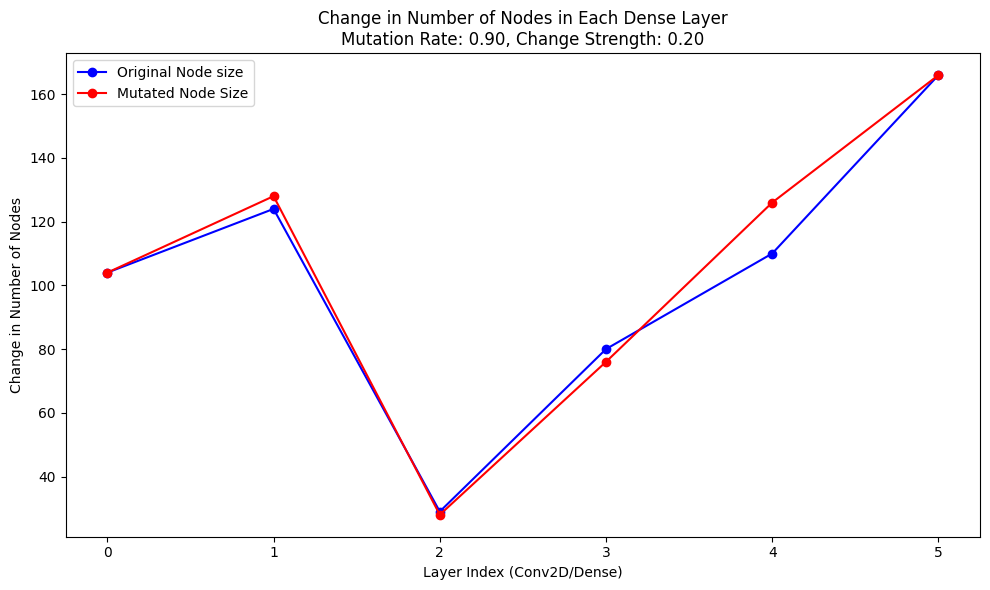

Genomes:  [['Conv2D', 112, (3, 5), 'tanh', 0.0076106259063023155], ['Conv2D', 55, (4, 3), 'tanh', 0.1], ['MaxPooling2D', (3, 2)], ['Flatten'], ['Dense', 92, 'sigmoid', 0.009220011759264393], ['Dense', 109, 'tanh', 0.06325828843510677], ['Dense', 166, 'relu', 0.03474262084558836]]
Compiled


In [27]:
best_model, test_data, test_labels, mean_accuracy_over_generations = genetic_algorithm(population_size=5, generations=5)

[14.0, 20.0, 28.0, 12.0, 16.0]


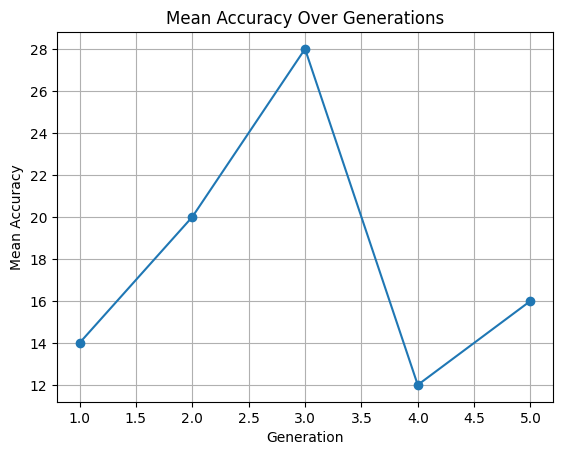

In [29]:
print(mean_accuracy_over_generations)

generations = range(1, len(mean_accuracy_over_generations) + 1)

plt.plot(generations, mean_accuracy_over_generations, marker='o', linestyle='-')
plt.title('Mean Accuracy Over Generations')
plt.xlabel('Generation')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()

In [13]:
# Get our best model and feed it all the training data to optimize it


train_data, train_labels = load_data(max_images_per_category = 1000)

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2)
train_data = train_data / 255.0
test_data = test_data / 255.0
train_labels_one_hot = to_categorical(train_labels, num_classes=num_characters)
test_labels_one_hot = to_categorical(test_labels, num_classes=num_characters)

start_time = time.time()
best_model.fit(train_data, train_labels_one_hot, epochs=4, batch_size=128, verbose=1)
finish_time = time.time()
execution_time = finish_time - start_time
print("Fitted in ", abs(execution_time), "'s.")
_, accuracy = best_model.evaluate(test_data, test_labels_one_hot, verbose=0)
print("Accuracy is ", accuracy)

display_model(best_model, accuracy)



Loaded 9898 images.
Epoch 1/4
 9/62 [===>..........................] - ETA: 7:05 - loss: 41.3289 - accuracy: 0.0842

KeyboardInterrupt: 

In [ ]:
# Display function using subplots
def display_predictions(images, predicted_labels, actual_labels, label_names):
    num_images = len(images)
    plt.figure(figsize=(20, 10))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Predicted: {label_names[predicted_labels[i]]}\nActual: {label_names[actual_labels[i]]}")
        plt.axis('off')

    plt.show()

# Label names (adjust according to your dataset)
label_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Number of images to display
num_images_to_display = 10

# Lists to store images, predicted labels, and actual labels
images = []
predicted_labels = []
actual_labels = []

# Iterate over a batch of test images
for _ in range(num_images_to_display):  # Adjust the range as needed
    i = random.randint(0, len(test_labels))
    image = test_data[i]
    actual_label = test_labels[i]
    predicted_label = np.argmax(best_model.predict(np.expand_dims(image, axis=0), verbose = 0))

    # Append to lists
    images.append(image)
    predicted_labels.append(predicted_label)
    actual_labels.append(actual_label)

# Display the predictions in subplots
display_predictions(images, predicted_labels, actual_labels, label_names)


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

import io
import time
import numpy as np
from IPython.display import Javascript, display
from base64 import b64decode
from google.colab.output import eval_js

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

       // Add event listener for spacebar press
      document.addEventListener('keydown', function(event) {
        if (event.code === 'Space') {
          const data = capturePhoto();
          google.colab.kernel.invokeFunction('save_photo', [data]);
        }
      });

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
def load_and_preprocess_image(image_path):
    # Load the original image
    original_image = PILImage.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # Step 1: Scale the image to 64 pixels in height while maintaining aspect ratio
    target_height = 64
    aspect_ratio = original_image.width / original_image.height
    new_width = int(target_height * aspect_ratio)
    scaled_image = original_image.resize((new_width, target_height))
    plt.subplot(2, 3, 2)
    plt.imshow(scaled_image)
    plt.title("Scaled Image")
    plt.axis('off')

    # Step 2: Crop the central 64x64 region
    left = (new_width - 64) // 2
    right = left + 64
    cropped_image = scaled_image.crop((left, 0, right, target_height))
    plt.subplot(2, 3, 3)
    plt.imshow(cropped_image)
    plt.title("Cropped Image")
    plt.axis('off')

    # Step 3: Convert the image to grayscale
    grayscale_image = cropped_image.convert('L')
    plt.subplot(2, 3, 4)
    plt.imshow(grayscale_image, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')

    # Step 4: Convert the grayscale image to a numpy array
    grayscale_array = np.array(grayscale_image)

    # Step 5: Apply thresholding to convert to black and white
    threshold = 100
    binary_array = (grayscale_array > threshold) * 255

    # Step 6: Invert the binary array
    inverted_array = 255 - binary_array

    # Step 7: Convert to RGB format by stacking the array along the last dimension
    rgb_array = np.stack((inverted_array,)*3, axis=-1)

    # Step 8: Add a batch dimension (1, 64, 64, 3)
    rgb_array = np.expand_dims(rgb_array, axis=0)

    plt.subplot(2, 3, 5)
    plt.imshow(inverted_array, cmap='gray')
    plt.title("Binary Image")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(rgb_array[0])
    plt.title("Final RGB Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return rgb_array

def display_image_with_prediction(image_path, predicted_label, preprocessed_image):
    # Load the original image
    img = PILImage.open(image_path)

    # Display the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    # Display the preprocessed image
    preprocessed_image = preprocessed_image.squeeze()  # Remove batch dimension
    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed_image)
    plt.title(f"Preprocessed Image\nPredicted Label: {predicted_label}")
    plt.axis('off')

    plt.show()

In [ ]:
from IPython.display import Image, clear_output
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  image_array = load_and_preprocess_image(filename)

  print(image_array.shape)

  predicted_label = np.argmax(best_model.predict(image_array, verbose = 0))

  # Show the image which was just taken.
  display_image_with_prediction(filename, predicted_label, image_array)


except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  print(str(err))